#Classify Mutations

This script takes the feature vectors as input and uses a random forest classifer to separate the mutations as cancer-causing or passenger. 

In [188]:
%pylab inline
import pandas as pd
import numpy as np
import os
import sklearn as sk
from sklearn.cluster import AffinityPropagation
from sklearn import datasets
from sklearn import metrics
from multiprocessing import Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.decomposition import PCA
import matplotlib.cm as cm

Populating the interactive namespace from numpy and matplotlib


In [133]:
cancer_feature_vector = pd.read_csv('../data_frames/cancer_feature_vector_tcga.csv', index_col=0)
neutral_feature_vector = pd.read_csv('../data_frames/neutral_feature_vector_tcga.csv', index_col=0)
cancer_feature_vector_training = pd.read_csv('../data_frames/cancer_feature_vector_tcga_training.csv', index_col=0)
neutral_feature_vector_training = pd.read_csv('../data_frames/neutral_feature_vector_tcga_training.csv', index_col=0)
cancer_feature_vector_validation = pd.read_csv('../data_frames/cancer_feature_vector_tcga_validation.csv', index_col=0)
neutral_feature_vector_validation = pd.read_csv('../data_frames/neutral_feature_vector_tcga_validation.csv', index_col=0)

using whole set

In [134]:
cancer_feature_vector = cancer_feature_vector.fillna(0)
cancer_matrix = cancer_feature_vector.values[:,1:].astype(float32)
neutral_feature_vector = neutral_feature_vector.fillna(0)
neutral_matrix = neutral_feature_vector.values[:,1:].astype(float32)
both_matrix = np.concatenate((cancer_matrix, neutral_matrix), axis=0)
assignments = [1 for gene in range(len(cancer_matrix))] + [0 for gene in range(len(neutral_matrix))]
#print both_matrix
#print assignments

training set

In [135]:
cancer_feature_vector_training = cancer_feature_vector_training.fillna(0)
cancer_matrix = cancer_feature_vector_training.values[:,1:].astype(float32)
neutral_feature_vector_training = neutral_feature_vector_training.fillna(0)
neutral_matrix = neutral_feature_vector_training.values[:,1:].astype(float32)
training_matrix = np.concatenate((cancer_matrix, neutral_matrix), axis=0)
training_assignments = [1 for gene in range(len(cancer_matrix))] + [0 for gene in range(len(neutral_matrix))]

validation set

In [137]:
cancer_feature_vector_validation = cancer_feature_vector_validation.fillna(0)
cancer_matrix = cancer_feature_vector_validation.values[:,1:].astype(float32)
neutral_feature_vector_validation = neutral_feature_vector_validation.fillna(0)
neutral_matrix = neutral_feature_vector_validation.values[:,1:].astype(float32)
validation_matrix = np.concatenate((cancer_matrix, neutral_matrix), axis=0)
validation_key = [1 for gene in range(len(cancer_matrix))] + [0 for gene in range(len(neutral_matrix))]

In [139]:
# create mutations array to predict upon
tcga_feature_vector = pd.read_csv('../data_frames/tcga_feature_vector.csv', index_col=0)
tcga_feature_vector = tcga_feature_vector.fillna(0)
tcga_matrix = tcga_feature_vector.values[:,1:].astype(float32)

In [140]:
tcga_feature_vector.head()

,SNP,counts,Perc_Bi_Allelic,Density
0,673_140453136,480,0.508333,1298.9
248,673_140453135,3,0.333333,1298.9
249,673_140477840,2,0.500000,1298.9
250,673_140453193,2,0.500000,1298.9
251,673_140477827,2,0.500000,1298.9


In [41]:
mr = pd.read_csv('../data_frames/mr.csv', index_col=0)
hugo_entrez = mr[['Hugo_Symbol', 'Entrez_Gene_Id']]
hugo_entrez = hugo_entrez.drop_duplicates()

### Random Tree Classifier

####Load an old classifier

In [223]:
clf = joblib.load('../classifiers/random_forest.pkl') 

####Or create a new one...

In [52]:
clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=5)
clf = clf.fit(training_matrix, training_assignments)

In [224]:
output = clf.predict(tcga_matrix)

In [225]:
probabilities = clf.predict_proba(tcga_matrix)

In [226]:
clf.feature_importances_

array([ 0.25624301,  0.31      ,  0.41375699])

In [227]:
print list(output).count(0)
print list(output).count(1)

19346
638


In [228]:
validation_predictions = clf.predict(validation_matrix)
print list(validation_predictions)
print validation_key

[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [229]:
total, same = 0, 0
for index, classification in enumerate(validation_predictions):
    total += 1
    if validation_key[index] == validation_predictions[index]:
        same += 1
print float(same)/total

1.0


In [230]:
save = joblib.dump(clf, '../classifiers/random_forest.pkl') 

Perform principle component analysis

In [231]:
tcga_feature_vector.head()

,SNP,counts,Perc_Bi_Allelic,Density
0,673_140453136,480,0.508333,1298.9
248,673_140453135,3,0.333333,1298.9
249,673_140477840,2,0.500000,1298.9
250,673_140453193,2,0.500000,1298.9
251,673_140477827,2,0.500000,1298.9


In [232]:
pca = PCA(n_components=2)
pca.fit(tcga_feature_vector[['counts', 'Perc_Bi_Allelic', 'Density']])
PCA(copy=True, n_components=2, whiten=False)
print(pca.explained_variance_ratio_) 

[  9.99895671e-01   1.03045798e-04]


In [233]:
#X = np.concatenate((training_matrix, validation_matrix), axis=0)
X = np.concatenate((training_matrix, validation_matrix), axis=0)[1:]
#y = np.concatenate((training_assignments, validation_key), axis=0)
y = np.concatenate((training_assignments, validation_key), axis=0)[1:]
target_names = ['Driver', 'Passenger']

explained variance ratio (first two components): [  9.99916553e-01   8.32683509e-05]


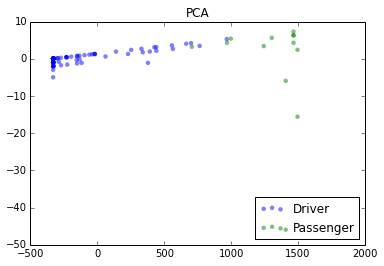

In [234]:
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LDA(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
for c, i, target_name in zip("bg", [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], c=c, alpha=0.5, label=target_name, edgecolors='none')
plt.legend(loc=4)
plt.title('PCA')

plt.show()

In [235]:
prob_df = pd.DataFrame(probabilities)

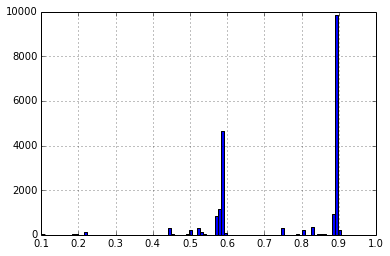

In [236]:
prob_df.columns = ['p_neutral', 'p_cancer']
prob_df.head()
prob_df.p_neutral.hist(bins=100)

###Look at difference between positive and negative features

In [237]:
cancer_feature_vector.describe()

,counts,Perc_Bi_Allelic,Density
count,14.000000,14.000000,14.000000
mean,42.714286,0.432143,1604.807143
std,126.683997,0.183417,258.092892
min,1.000000,0.000000,1035.300000
25%,2.000000,0.500000,1388.700000
50%,3.000000,0.500000,1736.600000
75%,12.000000,0.500000,1794.800000
max,480.000000,0.541667,1824.500000


In [238]:
neutral_feature_vector.describe()

,counts,Perc_Bi_Allelic,Density
count,113.000000,113.000000,113.000000
mean,1.477876,0.969027,152.095575
std,0.877266,0.167481,290.008532
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000
50%,1.000000,1.000000,0.000000
75%,2.000000,1.000000,178.600000
max,6.000000,1.000000,1296.600000


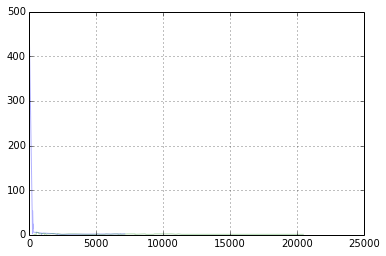

In [239]:
cancer_feature_vector.counts.plot(alpha=0.3)
neutral_feature_vector.counts.plot(alpha=0.3)

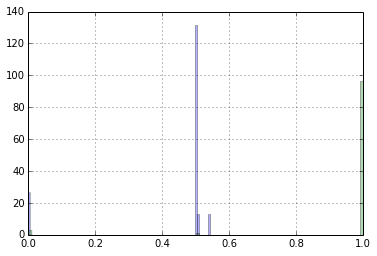

In [240]:
cancer_feature_vector.Perc_Bi_Allelic.hist(normed=True, alpha=0.3, bins=100)
neutral_feature_vector.Perc_Bi_Allelic.hist(normed=True, alpha=0.3, bins=100)

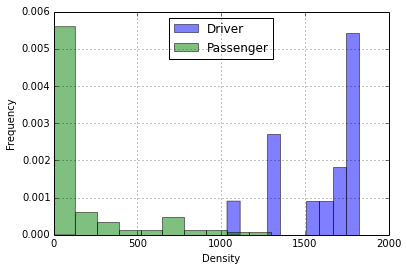

In [241]:
ax = cancer_feature_vector.Density.hist(normed=True, alpha=0.5, color='b', label='Driver')
neutral_feature_vector.Density.hist(normed=True, alpha=0.5, ax=ax, color='g', label='Passenger')
ax.set_xlabel("Density")
ax.set_ylabel("Frequency")
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc=9)

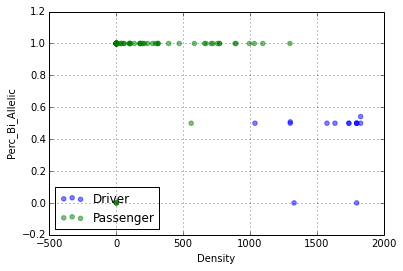

In [242]:
ax = cancer_feature_vector.plot(kind='scatter', y='Perc_Bi_Allelic', x='Density',
                                        color='b', alpha=0.5, label='Driver')

neutral_feature_vector.plot(kind='scatter', y='Perc_Bi_Allelic', x='Density',
                                        color='g', alpha=0.5, label='Passenger', ax=ax)
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc=3)

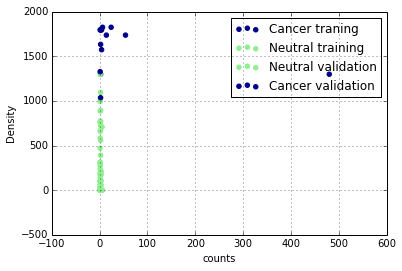

In [243]:
ax = cancer_feature_vector_training.plot(kind='scatter', x='counts', y='Density',
                                        color='DarkBlue', label='Cancer traning')
neutral_feature_vector_training.plot(kind='scatter', x='counts', y='Density',
                                        color='LightGreen', label='Neutral training', ax=ax)
neutral_feature_vector_validation.plot(kind='scatter', x='counts', y='Density',
                                        color='LightGreen', label='Neutral validation', ax=ax)
cancer_feature_vector_validation.plot(kind='scatter', x='counts', y='Density',
                                        color='DarkBlue', label='Cancer validation', ax=ax)

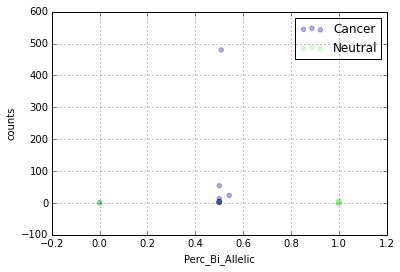

In [244]:
ax = cancer_feature_vector.plot(kind='scatter', x='Perc_Bi_Allelic', y='counts',
                                        color='DarkBlue', label='Cancer', alpha=0.3)
neutral_feature_vector.plot(kind='scatter', x='Perc_Bi_Allelic', y='counts',
                                        color='LightGreen', label='Neutral', ax=ax, alpha=0.3)
#cancer_feature_vector.plot(kind='scatter', x='Perc_Bi_Allelic', y='counts',
#                                        color='DarkBlue', label='Cancer', ax=ax)
#neutral_feature_vector_validation.plot(kind='scatter', x='Perc_Bi_Allelic', y='counts',
#                                        color='LightGreen', label='Neutral', ax=ax)
#cancer_feature_vector_validation.plot(kind='scatter', x='Perc_Bi_Allelic', y='counts',
#                                        color='LightBlue', label='Cancer', ax=ax)

In [245]:
def simplify(x):
    a = x.split("_")
    return a[0]
def get_loc(x):
    c = x.split(":")
    s = c[1].split("-")
    return s[0]
def combine(x):
    gene = x[0]
    loc = x[1]
    return str(int(gene)) + "_" + str(loc)
def return_position(x):
    c = x.split("_")
    return c[1]

In [246]:
tcga_feature_vector['output'] = pd.Series(output)

In [247]:
tcga_feature_vector[tcga_feature_vector['output'] == 1].head()

,SNP,counts,Perc_Bi_Allelic,Density,output
0,673_140453136,480,0.508333,1298.9,1
258,673_140477846,1,1.000000,1298.9,1
386,115294_52733143,8,1.000000,201.6,1
527,996_45214726,1,1.000000,1030.3,1
529,996_45214603,1,1.000000,1030.3,1


In [248]:
tcga_feature_vector['Entrez_Gene_Id'] = tcga_feature_vector['SNP'].apply(simplify)
tcga_feature_vector['Entrez_Gene_Id'] = tcga_feature_vector['Entrez_Gene_Id'].astype(int)

In [249]:
tcga_feature_vector.dtypes

SNP                 object
counts             float64
Perc_Bi_Allelic    float64
Density            float64
output             float64
Entrez_Gene_Id       int64
dtype: object

In [250]:
hugo_entrez.dtypes

Hugo_Symbol       object
Entrez_Gene_Id     int64
dtype: object

In [251]:
tcga_feature_vector.head()

,SNP,counts,Perc_Bi_Allelic,Density,output,Entrez_Gene_Id
0,673_140453136,480,0.508333,1298.9,1,673
248,673_140453135,3,0.333333,1298.9,0,673
249,673_140477840,2,0.500000,1298.9,0,673
250,673_140453193,2,0.500000,1298.9,0,673
251,673_140477827,2,0.500000,1298.9,0,673


In [252]:
tcga_feature_vector = pd.merge(tcga_feature_vector, hugo_entrez, on="Entrez_Gene_Id", how="inner")

In [253]:
tcga_feature_vector.head()

,SNP,counts,Perc_Bi_Allelic,Density,output,Entrez_Gene_Id,Hugo_Symbol
0,673_140453136,480,0.508333,1298.9,1,673,BRAF
1,673_140453135,3,0.333333,1298.9,0,673,BRAF
2,673_140477840,2,0.500000,1298.9,0,673,BRAF
3,673_140453193,2,0.500000,1298.9,0,673,BRAF
4,673_140477827,2,0.500000,1298.9,0,673,BRAF


In [254]:
tcga_cancer = tcga_feature_vector[tcga_feature_vector.output == 1]

In [255]:
tcga_neutral = tcga_feature_vector[tcga_feature_vector.output == 0]

In [256]:
tcga_cancer["Occurances"] = tcga_cancer.counts

In [257]:
tcga_cancer[['Hugo_Symbol', 'Occurances', 'Perc_Bi_Allelic', 'Density']][100:103]

,Hugo_Symbol,Occurances,Perc_Bi_Allelic,Density
1550,PKD1,1,0,652
1551,PKD1,1,1,652
1552,PKD1,1,1,652


In [258]:
tcga_cancer.head()

,SNP,counts,Perc_Bi_Allelic,Density,output,Entrez_Gene_Id,Hugo_Symbol,Occurances
0,673_140453136,480,0.508333,1298.9,1,673,BRAF,480
11,673_140477846,1,1.000000,1298.9,1,673,BRAF,1
90,115294_52733143,8,1.000000,201.6,1,115294,PCMTD1,8
226,996_45214726,1,1.000000,1030.3,1,996,CDC27,1
228,996_45214603,1,1.000000,1030.3,1,996,CDC27,1


In [259]:
tcga_cancer.to_csv(open('../data_frames/tcga_cancerous_mutations.csv', 'w'))
tcga_neutral.to_csv(open('../data_frames/tcga_neutral_mutations.csv', 'w'))

In [260]:
tcga_cancer['Chromosomal Position'] = tcga_cancer.SNP.map(return_position)

In [266]:
tcga_cancer.reset_index()[['Hugo_Symbol', 'Chromosomal Position']].to_csv("../data_frames/driver_mutations.csv")

In [267]:
tcga_cancer.reset_index()[['Hugo_Symbol', 'Chromosomal Position']].head(10)

,Hugo_Symbol,Chromosomal Position
0,BRAF,140453136
1,BRAF,140477846
2,PCMTD1,52733143
3,CDC27,45214726
4,CDC27,45214603
5,CDC27,45234287
6,CDC27,45219311
7,CDC27,45214631
8,CDC27,45247398
9,CDC27,45214559
